# 기본 LSTM 모델 
LSTM을 제대로 활용하기 위해서는 상태유지 모드, 배치사이즈, 타임스텝, 속성에 대한 개념에 이해가 필요합니다
- 타임스텝이란 하나의 샘플에 포함된 시퀀스 개수입니다. 이는 앞서 살펴본 “input_length”와 동일합니다. 
- 윈도우 크기와 동일하게 타임스텝으로 설정하면 됩니다. 
- 설정한 LSTM 모델에 따라 입력할 데이터셋도 샘플 수, 타임스텝 수, 속성 수 형식으로 맞추어야 합니다. 

## 0. 사용할 패키지 불러오기 

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback
import numpy as np

### 0.1 랜덤시드 고정하기 
동일한 결과를 얻기 위해 시드를 고정한다.

In [2]:
np.random.seed(5)

### 0.2 손실 이력 클래스 정의

In [3]:
class LossHistory(Callback):
    def init(self):
        self.losses = []
    
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))  
        

## 1. 데이터셋 생성
### 1.1 코드 변환 사전
* code2idx : 코드를 숫자로 변환 
* idx2code : 숫자를 코드로 변환

In [4]:
code2idx = {'c4':0, 'd4':1, 'e4':2, 'f4':3, 'g4':4, 'a4':5, 'b4':6,
            'c8':7, 'd8':8, 'e8':9, 'f8':10, 'g8':11, 'a8':12, 'b8':13}

idx2code = {0:'c4', 1:'d4', 2:'e4', 3:'f4', 4:'g4', 5:'a4', 6:'b4',
            7:'c8', 8:'d8', 9:'e8', 10:'f8', 11:'g8', 12:'a8', 13:'b8'}

### 1.2 데이터 셋 생성 함수 정의 
- 사전을 이용해서 순차적인 음표를 우리가 지정한 윈도우 크기만큼 잘라 데이터셋을 생성하는 함수를 정의

In [5]:
def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)

### 1.3 데이터 셋

In [6]:
# 시퀀스 데이터 정의 
seq = ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'd8', 'e8', 'f8', 'g8', 'g8', 'g4',
       'g8', 'e8', 'e8', 'e8', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4',
       'd8', 'd8', 'd8', 'd8', 'd8', 'e8', 'f4', 'e8', 'e8', 'e8', 'e8', 'e8', 'f8', 'g4',
       'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']

dataset = seq2dataset(seq, window_size = 4)

print(dataset.shape)
print(dataset)

(50, 5)
[[11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  8]
 [ 8  1  7  8  9]
 [ 1  7  8  9 10]
 [ 7  8  9 10 11]
 [ 8  9 10 11 11]
 [ 9 10 11 11  4]
 [10 11 11  4 11]
 [11 11  4 11  9]
 [11  4 11  9  9]
 [ 4 11  9  9  9]
 [11  9  9  9 10]
 [ 9  9  9 10  8]
 [ 9  9 10  8  1]
 [ 9 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]
 [11  9  9  2  8]
 [ 9  9  2  8  8]
 [ 9  2  8  8  8]
 [ 2  8  8  8  8]
 [ 8  8  8  8  8]
 [ 8  8  8  8  9]
 [ 8  8  8  9  3]
 [ 8  8  9  3  9]
 [ 8  9  3  9  9]
 [ 9  3  9  9  9]
 [ 3  9  9  9  9]
 [ 9  9  9  9  9]
 [ 9  9  9  9 10]
 [ 9  9  9 10  4]
 [ 9  9 10  4 11]
 [ 9 10  4 11  9]
 [10  4 11  9  2]
 [ 4 11  9  2 10]
 [11  9  2 10  8]
 [ 9  2 10  8  1]
 [ 2 10  8  1  7]
 [10  8  1  7  9]
 [ 8  1  7  9 11]
 [ 1  7  9 11 11]
 [ 7  9 11 11  9]
 [ 9 11 11  9  9]
 [11 11  9  9  2]]


### 1.4 데이터 준비 

#### 1.4.1 입력과 출력 변수로 분리 

In [7]:
x_train = dataset[:, 0:4]
y_train = dataset[:, 4]
max_idx_value = 13
print(x_train)
print(y_train)

[[11  9  2 10]
 [ 9  2 10  8]
 [ 2 10  8  1]
 [10  8  1  7]
 [ 8  1  7  8]
 [ 1  7  8  9]
 [ 7  8  9 10]
 [ 8  9 10 11]
 [ 9 10 11 11]
 [10 11 11  4]
 [11 11  4 11]
 [11  4 11  9]
 [ 4 11  9  9]
 [11  9  9  9]
 [ 9  9  9 10]
 [ 9  9 10  8]
 [ 9 10  8  1]
 [10  8  1  7]
 [ 8  1  7  9]
 [ 1  7  9 11]
 [ 7  9 11 11]
 [ 9 11 11  9]
 [11 11  9  9]
 [11  9  9  2]
 [ 9  9  2  8]
 [ 9  2  8  8]
 [ 2  8  8  8]
 [ 8  8  8  8]
 [ 8  8  8  8]
 [ 8  8  8  9]
 [ 8  8  9  3]
 [ 8  9  3  9]
 [ 9  3  9  9]
 [ 3  9  9  9]
 [ 9  9  9  9]
 [ 9  9  9  9]
 [ 9  9  9 10]
 [ 9  9 10  4]
 [ 9 10  4 11]
 [10  4 11  9]
 [ 4 11  9  2]
 [11  9  2 10]
 [ 9  2 10  8]
 [ 2 10  8  1]
 [10  8  1  7]
 [ 8  1  7  9]
 [ 1  7  9 11]
 [ 7  9 11 11]
 [ 9 11 11  9]
 [11 11  9  9]]
[ 8  1  7  8  9 10 11 11  4 11  9  9  9 10  8  1  7  9 11 11  9  9  2  8
  8  8  8  8  9  3  9  9  9  9  9 10  4 11  9  2 10  8  1  7  9 11 11  9
  9  2]


#### 1.4.2 입력값 정규화 시키기

In [8]:
x_train = x_train / float(max_idx_value)
print(x_train)

[[0.84615385 0.69230769 0.15384615 0.76923077]
 [0.69230769 0.15384615 0.76923077 0.61538462]
 [0.15384615 0.76923077 0.61538462 0.07692308]
 [0.76923077 0.61538462 0.07692308 0.53846154]
 [0.61538462 0.07692308 0.53846154 0.61538462]
 [0.07692308 0.53846154 0.61538462 0.69230769]
 [0.53846154 0.61538462 0.69230769 0.76923077]
 [0.61538462 0.69230769 0.76923077 0.84615385]
 [0.69230769 0.76923077 0.84615385 0.84615385]
 [0.76923077 0.84615385 0.84615385 0.30769231]
 [0.84615385 0.84615385 0.30769231 0.84615385]
 [0.84615385 0.30769231 0.84615385 0.69230769]
 [0.30769231 0.84615385 0.69230769 0.69230769]
 [0.84615385 0.69230769 0.69230769 0.69230769]
 [0.69230769 0.69230769 0.69230769 0.76923077]
 [0.69230769 0.69230769 0.76923077 0.61538462]
 [0.69230769 0.76923077 0.61538462 0.07692308]
 [0.76923077 0.61538462 0.07692308 0.53846154]
 [0.61538462 0.07692308 0.53846154 0.69230769]
 [0.07692308 0.53846154 0.69230769 0.84615385]
 [0.53846154 0.69230769 0.84615385 0.84615385]
 [0.69230769 

#### 1.4.3 라벨값에 대한 one-hot 인코딩 수행 

In [9]:
y_train = to_categorical(y_train)
print(y_train)    # 원-핫-인코딩 
one_hot_vec_size = y_train.shape[1]
print("one hot encoding vector size is ", one_hot_vec_size)

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.

## 2. 학습 과정 
학습시키는 방식 
- 파란색 박스가 입력값이고, 빨간색 박스가 우리가 원하는 출력값입니다.
- 1~4번째 음표를 데이터로 5번째 음표를 라벨값으로 학습을 시킵니다.
- 다음에는 2~5번째 음표를 데이터로 6번째 음표를 라벨값으로 학습을 시킵니다.
- 이후 한 음표씩 넘어가면서 노래 끝까지 학습시킵니다.

## 3 예측 과정 
### 3.1 한 스탭 예측 
한 스텝 예측이란 실제 음표 4개를 입력하여 다음 음표 1개를 예측하는 것을 반복하는 것입니다. 이 방법에서는 모델의 입력값으로는 항상 실제 음표가 들어갑니다.

- 모델에 t0, t1, t2, t3를 입력하면 y0 출력이 나옵니다.
- 모델에 t1, t2, t3, t4를 입력하면 y1 출력이 나옵니다.
- 모델에 t2, t3, t4, t5를 입력하면 y2 출력이 나옵니다.
- 이 과정을 y49 출력까지 반복합니다.

### 3.2 곡 전체 예측
곡 전체 예측이란 입력된 초가 4개 음표만을 입력으로 곡 전체를 예측하는 것입니다. 초반부가 지나면, 예측값만으로 모델에 입력되어 다음 예측값이 나오는 식입니다. 그야말로 “나비야~ 나”까지 알려주면 나머지까지 모두 연주를 하는 것이죠. 만약 중간에 틀린 부분이 생긴다면, 이후 음정, 박자는 모두 이상하게 될 가능성이 많습니다. 예측 오류가 누적되는 것이겠죠.

- 모델에 t0, t1, t2, t3를 입력하면 y0 출력이 나옵니다.
- 예측값인 y0를 t4라고 가정하고, 모델에 t1, t2, t3, t4을 입력하면 y1 출력이 나옵니다.
- 예측값인 y1을 t5라고 가정하고, 모델에 t2, t3, t4(예측값), t5(예측값)을 입력하면 y2 출력이 나옵니다.
- 이 과정을 y49 출력까지 반복합니다.

## 4 다층 퍼셉트론 신경망 모델 
앞서 생성한 데이터셋으로 먼저 다층 퍼셉트론 모델을 학습시켜보겠습니다. Dense 레이어 3개로 구성하였고, 입력 속성이 4개이고 출력이 12개(one_hot_vec_size=12)으로 설정했습니다.

### 4.1 모델 생성하기
모델 구성 
- 128 메모리 셀을 가진 LSTM 레이어 1개와 Dense 레이어로 구성
- 입력은 샘플이 50개, 타임스텝이 4개, 속성이 1개로 구성
- 상태유지(stateful) 모드 비활성화
- 인자로 “input_shape = (4, 1)’과 “input_dim = 1, input_length = 4”는 동일합니다.

In [10]:
model = Sequential()
model.add(LSTM(128, input_shape =(4,1)))
model.add(Dense(one_hot_vec_size, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               640       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 12)                1548      
Total params: 18,700
Trainable params: 18,700
Non-trainable params: 0
_________________________________________________________________


### 4.2 모델 구성 확인

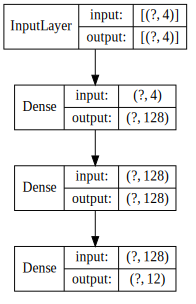

In [11]:
from IPython.display import SVG, display
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model
import os

os.environ["PATH"] += os.pathsep + "C:/Program Files (x86)/Graphviz2.38/bin"

%matplotlib inline

iv1_dot = model_to_dot(model, show_shapes=True, show_layer_names=False, dpi=70)   # 사이즈 변경하기 
plot_model(model, to_file='model.png')
display(SVG(iv1_dot.create(prog=['dot'], format='svg')))

## 5 모델 학습과정 설정 

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = LossHistory() # 손실 이력 객체 생성
history.init()

## 6 모델 학습시키기

In [13]:
hist = model.fit(x_train, y_train, epochs=2000, batch_size=10, verbose=2, callbacks=[history])

Epoch 1/2000
5/5 - 0s - loss: 2.4763 - accuracy: 0.1600
Epoch 2/2000
5/5 - 0s - loss: 2.3711 - accuracy: 0.3400
Epoch 3/2000
5/5 - 0s - loss: 2.2842 - accuracy: 0.3400
Epoch 4/2000
5/5 - 0s - loss: 2.2135 - accuracy: 0.3400
Epoch 5/2000
5/5 - 0s - loss: 2.1184 - accuracy: 0.3400
Epoch 6/2000
5/5 - 0s - loss: 2.0568 - accuracy: 0.3400
Epoch 7/2000
5/5 - 0s - loss: 2.0006 - accuracy: 0.3400
Epoch 8/2000
5/5 - 0s - loss: 1.9641 - accuracy: 0.3400
Epoch 9/2000
5/5 - 0s - loss: 1.9257 - accuracy: 0.3400
Epoch 10/2000
5/5 - 0s - loss: 1.8976 - accuracy: 0.3400
Epoch 11/2000
5/5 - 0s - loss: 1.8750 - accuracy: 0.3400
Epoch 12/2000
5/5 - 0s - loss: 1.8520 - accuracy: 0.3400
Epoch 13/2000
5/5 - 0s - loss: 1.8378 - accuracy: 0.3400
Epoch 14/2000
5/5 - 0s - loss: 1.8204 - accuracy: 0.3400
Epoch 15/2000
5/5 - 0s - loss: 1.8068 - accuracy: 0.3400
Epoch 16/2000
5/5 - 0s - loss: 1.7924 - accuracy: 0.3400
Epoch 17/2000
5/5 - 0s - loss: 1.7776 - accuracy: 0.3400
Epoch 18/2000
5/5 - 0s - loss: 1.7615 - 

Epoch 145/2000
5/5 - 0s - loss: 1.1613 - accuracy: 0.5800
Epoch 146/2000
5/5 - 0s - loss: 1.1643 - accuracy: 0.5800
Epoch 147/2000
5/5 - 0s - loss: 1.1631 - accuracy: 0.5400
Epoch 148/2000
5/5 - 0s - loss: 1.1583 - accuracy: 0.6000
Epoch 149/2000
5/5 - 0s - loss: 1.1524 - accuracy: 0.5800
Epoch 150/2000
5/5 - 0s - loss: 1.1495 - accuracy: 0.5800
Epoch 151/2000
5/5 - 0s - loss: 1.1458 - accuracy: 0.5800
Epoch 152/2000
5/5 - 0s - loss: 1.1413 - accuracy: 0.6000
Epoch 153/2000
5/5 - 0s - loss: 1.1392 - accuracy: 0.6000
Epoch 154/2000
5/5 - 0s - loss: 1.1313 - accuracy: 0.5800
Epoch 155/2000
5/5 - 0s - loss: 1.1318 - accuracy: 0.5800
Epoch 156/2000
5/5 - 0s - loss: 1.1295 - accuracy: 0.5800
Epoch 157/2000
5/5 - 0s - loss: 1.1422 - accuracy: 0.5600
Epoch 158/2000
5/5 - 0s - loss: 1.1260 - accuracy: 0.5800
Epoch 159/2000
5/5 - 0s - loss: 1.1230 - accuracy: 0.5800
Epoch 160/2000
5/5 - 0s - loss: 1.1207 - accuracy: 0.5800
Epoch 161/2000
5/5 - 0s - loss: 1.1200 - accuracy: 0.5800
Epoch 162/2000

Epoch 287/2000
5/5 - 0s - loss: 0.8181 - accuracy: 0.6400
Epoch 288/2000
5/5 - 0s - loss: 0.8203 - accuracy: 0.6400
Epoch 289/2000
5/5 - 0s - loss: 0.8158 - accuracy: 0.6600
Epoch 290/2000
5/5 - 0s - loss: 0.8180 - accuracy: 0.6400
Epoch 291/2000
5/5 - 0s - loss: 0.8081 - accuracy: 0.6600
Epoch 292/2000
5/5 - 0s - loss: 0.8142 - accuracy: 0.6400
Epoch 293/2000
5/5 - 0s - loss: 0.8049 - accuracy: 0.6800
Epoch 294/2000
5/5 - 0s - loss: 0.8035 - accuracy: 0.6600
Epoch 295/2000
5/5 - 0s - loss: 0.8036 - accuracy: 0.6600
Epoch 296/2000
5/5 - 0s - loss: 0.7957 - accuracy: 0.7000
Epoch 297/2000
5/5 - 0s - loss: 0.8080 - accuracy: 0.6800
Epoch 298/2000
5/5 - 0s - loss: 0.8004 - accuracy: 0.6200
Epoch 299/2000
5/5 - 0s - loss: 0.8004 - accuracy: 0.6600
Epoch 300/2000
5/5 - 0s - loss: 0.7923 - accuracy: 0.7000
Epoch 301/2000
5/5 - 0s - loss: 0.7894 - accuracy: 0.7200
Epoch 302/2000
5/5 - 0s - loss: 0.7871 - accuracy: 0.6800
Epoch 303/2000
5/5 - 0s - loss: 0.7869 - accuracy: 0.6800
Epoch 304/2000

Epoch 429/2000
5/5 - 0s - loss: 0.5963 - accuracy: 0.7800
Epoch 430/2000
5/5 - 0s - loss: 0.5803 - accuracy: 0.7800
Epoch 431/2000
5/5 - 0s - loss: 0.5789 - accuracy: 0.8000
Epoch 432/2000
5/5 - 0s - loss: 0.5866 - accuracy: 0.8200
Epoch 433/2000
5/5 - 0s - loss: 0.5845 - accuracy: 0.8200
Epoch 434/2000
5/5 - 0s - loss: 0.5767 - accuracy: 0.7800
Epoch 435/2000
5/5 - 0s - loss: 0.5777 - accuracy: 0.8000
Epoch 436/2000
5/5 - 0s - loss: 0.5744 - accuracy: 0.8000
Epoch 437/2000
5/5 - 0s - loss: 0.5775 - accuracy: 0.7800
Epoch 438/2000
5/5 - 0s - loss: 0.5762 - accuracy: 0.8000
Epoch 439/2000
5/5 - 0s - loss: 0.5703 - accuracy: 0.8000
Epoch 440/2000
5/5 - 0s - loss: 0.5692 - accuracy: 0.7800
Epoch 441/2000
5/5 - 0s - loss: 0.5669 - accuracy: 0.7800
Epoch 442/2000
5/5 - 0s - loss: 0.5644 - accuracy: 0.8000
Epoch 443/2000
5/5 - 0s - loss: 0.5721 - accuracy: 0.8000
Epoch 444/2000
5/5 - 0s - loss: 0.5698 - accuracy: 0.8200
Epoch 445/2000
5/5 - 0s - loss: 0.5677 - accuracy: 0.8200
Epoch 446/2000

Epoch 571/2000
5/5 - 0s - loss: 0.4498 - accuracy: 0.8400
Epoch 572/2000
5/5 - 0s - loss: 0.4474 - accuracy: 0.8600
Epoch 573/2000
5/5 - 0s - loss: 0.4413 - accuracy: 0.8600
Epoch 574/2000
5/5 - 0s - loss: 0.4466 - accuracy: 0.8600
Epoch 575/2000
5/5 - 0s - loss: 0.4427 - accuracy: 0.8600
Epoch 576/2000
5/5 - 0s - loss: 0.4423 - accuracy: 0.8600
Epoch 577/2000
5/5 - 0s - loss: 0.4482 - accuracy: 0.8400
Epoch 578/2000
5/5 - 0s - loss: 0.4542 - accuracy: 0.8400
Epoch 579/2000
5/5 - 0s - loss: 0.4330 - accuracy: 0.9000
Epoch 580/2000
5/5 - 0s - loss: 0.4426 - accuracy: 0.8800
Epoch 581/2000
5/5 - 0s - loss: 0.4382 - accuracy: 0.8600
Epoch 582/2000
5/5 - 0s - loss: 0.4473 - accuracy: 0.8400
Epoch 583/2000
5/5 - 0s - loss: 0.4380 - accuracy: 0.8800
Epoch 584/2000
5/5 - 0s - loss: 0.4322 - accuracy: 0.8800
Epoch 585/2000
5/5 - 0s - loss: 0.4405 - accuracy: 0.8800
Epoch 586/2000
5/5 - 0s - loss: 0.4321 - accuracy: 0.8800
Epoch 587/2000
5/5 - 0s - loss: 0.4375 - accuracy: 0.8600
Epoch 588/2000

Epoch 713/2000
5/5 - 0s - loss: 0.3441 - accuracy: 0.9000
Epoch 714/2000
5/5 - 0s - loss: 0.3498 - accuracy: 0.9000
Epoch 715/2000
5/5 - 0s - loss: 0.3501 - accuracy: 0.9200
Epoch 716/2000
5/5 - 0s - loss: 0.3433 - accuracy: 0.9000
Epoch 717/2000
5/5 - 0s - loss: 0.3588 - accuracy: 0.9000
Epoch 718/2000
5/5 - 0s - loss: 0.3432 - accuracy: 0.9200
Epoch 719/2000
5/5 - 0s - loss: 0.3532 - accuracy: 0.9000
Epoch 720/2000
5/5 - 0s - loss: 0.3579 - accuracy: 0.9000
Epoch 721/2000
5/5 - 0s - loss: 0.3515 - accuracy: 0.8800
Epoch 722/2000
5/5 - 0s - loss: 0.3497 - accuracy: 0.9200
Epoch 723/2000
5/5 - 0s - loss: 0.3521 - accuracy: 0.9000
Epoch 724/2000
5/5 - 0s - loss: 0.3444 - accuracy: 0.9000
Epoch 725/2000
5/5 - 0s - loss: 0.3386 - accuracy: 0.9200
Epoch 726/2000
5/5 - 0s - loss: 0.3534 - accuracy: 0.9000
Epoch 727/2000
5/5 - 0s - loss: 0.3457 - accuracy: 0.9000
Epoch 728/2000
5/5 - 0s - loss: 0.3389 - accuracy: 0.9200
Epoch 729/2000
5/5 - 0s - loss: 0.3478 - accuracy: 0.9200
Epoch 730/2000

Epoch 855/2000
5/5 - 0s - loss: 0.2864 - accuracy: 0.9200
Epoch 856/2000
5/5 - 0s - loss: 0.2911 - accuracy: 0.9000
Epoch 857/2000
5/5 - 0s - loss: 0.2856 - accuracy: 0.9200
Epoch 858/2000
5/5 - 0s - loss: 0.2852 - accuracy: 0.9200
Epoch 859/2000
5/5 - 0s - loss: 0.2788 - accuracy: 0.9200
Epoch 860/2000
5/5 - 0s - loss: 0.2895 - accuracy: 0.9200
Epoch 861/2000
5/5 - 0s - loss: 0.2870 - accuracy: 0.9200
Epoch 862/2000
5/5 - 0s - loss: 0.2798 - accuracy: 0.9200
Epoch 863/2000
5/5 - 0s - loss: 0.2831 - accuracy: 0.9200
Epoch 864/2000
5/5 - 0s - loss: 0.2813 - accuracy: 0.9200
Epoch 865/2000
5/5 - 0s - loss: 0.2858 - accuracy: 0.9000
Epoch 866/2000
5/5 - 0s - loss: 0.2839 - accuracy: 0.9000
Epoch 867/2000
5/5 - 0s - loss: 0.2826 - accuracy: 0.9200
Epoch 868/2000
5/5 - 0s - loss: 0.2777 - accuracy: 0.9200
Epoch 869/2000
5/5 - 0s - loss: 0.2815 - accuracy: 0.9000
Epoch 870/2000
5/5 - 0s - loss: 0.2779 - accuracy: 0.9200
Epoch 871/2000
5/5 - 0s - loss: 0.2809 - accuracy: 0.9000
Epoch 872/2000

Epoch 997/2000
5/5 - 0s - loss: 0.2399 - accuracy: 0.9200
Epoch 998/2000
5/5 - 0s - loss: 0.2468 - accuracy: 0.9000
Epoch 999/2000
5/5 - 0s - loss: 0.2628 - accuracy: 0.9200
Epoch 1000/2000
5/5 - 0s - loss: 0.2738 - accuracy: 0.9000
Epoch 1001/2000
5/5 - 0s - loss: 0.2509 - accuracy: 0.9200
Epoch 1002/2000
5/5 - 0s - loss: 0.2432 - accuracy: 0.8800
Epoch 1003/2000
5/5 - 0s - loss: 0.2538 - accuracy: 0.9000
Epoch 1004/2000
5/5 - 0s - loss: 0.2440 - accuracy: 0.9000
Epoch 1005/2000
5/5 - 0s - loss: 0.2460 - accuracy: 0.9200
Epoch 1006/2000
5/5 - 0s - loss: 0.2361 - accuracy: 0.9200
Epoch 1007/2000
5/5 - 0s - loss: 0.2450 - accuracy: 0.9000
Epoch 1008/2000
5/5 - 0s - loss: 0.2415 - accuracy: 0.9000
Epoch 1009/2000
5/5 - 0s - loss: 0.2401 - accuracy: 0.9000
Epoch 1010/2000
5/5 - 0s - loss: 0.2384 - accuracy: 0.9200
Epoch 1011/2000
5/5 - 0s - loss: 0.2387 - accuracy: 0.9000
Epoch 1012/2000
5/5 - 0s - loss: 0.2405 - accuracy: 0.9200
Epoch 1013/2000
5/5 - 0s - loss: 0.2424 - accuracy: 0.9200


Epoch 1136/2000
5/5 - 0s - loss: 0.2083 - accuracy: 0.9200
Epoch 1137/2000
5/5 - 0s - loss: 0.2177 - accuracy: 0.9200
Epoch 1138/2000
5/5 - 0s - loss: 0.2125 - accuracy: 0.9200
Epoch 1139/2000
5/5 - 0s - loss: 0.2138 - accuracy: 0.9200
Epoch 1140/2000
5/5 - 0s - loss: 0.2123 - accuracy: 0.9000
Epoch 1141/2000
5/5 - 0s - loss: 0.2148 - accuracy: 0.9000
Epoch 1142/2000
5/5 - 0s - loss: 0.2297 - accuracy: 0.9000
Epoch 1143/2000
5/5 - 0s - loss: 0.2128 - accuracy: 0.9200
Epoch 1144/2000
5/5 - 0s - loss: 0.2074 - accuracy: 0.9000
Epoch 1145/2000
5/5 - 0s - loss: 0.2218 - accuracy: 0.9000
Epoch 1146/2000
5/5 - 0s - loss: 0.2166 - accuracy: 0.9200
Epoch 1147/2000
5/5 - 0s - loss: 0.2152 - accuracy: 0.9000
Epoch 1148/2000
5/5 - 0s - loss: 0.2187 - accuracy: 0.9200
Epoch 1149/2000
5/5 - 0s - loss: 0.2256 - accuracy: 0.9000
Epoch 1150/2000
5/5 - 0s - loss: 0.2151 - accuracy: 0.9000
Epoch 1151/2000
5/5 - 0s - loss: 0.2256 - accuracy: 0.9200
Epoch 1152/2000
5/5 - 0s - loss: 0.2091 - accuracy: 0.92

Epoch 1275/2000
5/5 - 0s - loss: 0.1959 - accuracy: 0.9000
Epoch 1276/2000
5/5 - 0s - loss: 0.1881 - accuracy: 0.9200
Epoch 1277/2000
5/5 - 0s - loss: 0.1962 - accuracy: 0.9200
Epoch 1278/2000
5/5 - 0s - loss: 0.1904 - accuracy: 0.9200
Epoch 1279/2000
5/5 - 0s - loss: 0.1925 - accuracy: 0.9000
Epoch 1280/2000
5/5 - 0s - loss: 0.1924 - accuracy: 0.9200
Epoch 1281/2000
5/5 - 0s - loss: 0.1926 - accuracy: 0.9200
Epoch 1282/2000
5/5 - 0s - loss: 0.1943 - accuracy: 0.8800
Epoch 1283/2000
5/5 - 0s - loss: 0.1909 - accuracy: 0.9200
Epoch 1284/2000
5/5 - 0s - loss: 0.1916 - accuracy: 0.9000
Epoch 1285/2000
5/5 - 0s - loss: 0.2020 - accuracy: 0.9200
Epoch 1286/2000
5/5 - 0s - loss: 0.1926 - accuracy: 0.9200
Epoch 1287/2000
5/5 - 0s - loss: 0.1927 - accuracy: 0.9400
Epoch 1288/2000
5/5 - 0s - loss: 0.2069 - accuracy: 0.8800
Epoch 1289/2000
5/5 - 0s - loss: 0.1989 - accuracy: 0.9000
Epoch 1290/2000
5/5 - 0s - loss: 0.2054 - accuracy: 0.9200
Epoch 1291/2000
5/5 - 0s - loss: 0.1898 - accuracy: 0.92

Epoch 1414/2000
5/5 - 0s - loss: 0.1876 - accuracy: 0.9000
Epoch 1415/2000
5/5 - 0s - loss: 0.1785 - accuracy: 0.9200
Epoch 1416/2000
5/5 - 0s - loss: 0.1742 - accuracy: 0.9200
Epoch 1417/2000
5/5 - 0s - loss: 0.1950 - accuracy: 0.9200
Epoch 1418/2000
5/5 - 0s - loss: 0.1764 - accuracy: 0.9200
Epoch 1419/2000
5/5 - 0s - loss: 0.1830 - accuracy: 0.8800
Epoch 1420/2000
5/5 - 0s - loss: 0.1756 - accuracy: 0.9200
Epoch 1421/2000
5/5 - 0s - loss: 0.1937 - accuracy: 0.9000
Epoch 1422/2000
5/5 - 0s - loss: 0.1933 - accuracy: 0.9200
Epoch 1423/2000
5/5 - 0s - loss: 0.1861 - accuracy: 0.9200
Epoch 1424/2000
5/5 - 0s - loss: 0.1822 - accuracy: 0.9200
Epoch 1425/2000
5/5 - 0s - loss: 0.1722 - accuracy: 0.9000
Epoch 1426/2000
5/5 - 0s - loss: 0.1764 - accuracy: 0.9000
Epoch 1427/2000
5/5 - 0s - loss: 0.1781 - accuracy: 0.9000
Epoch 1428/2000
5/5 - 0s - loss: 0.1809 - accuracy: 0.9000
Epoch 1429/2000
5/5 - 0s - loss: 0.1786 - accuracy: 0.9200
Epoch 1430/2000
5/5 - 0s - loss: 0.1771 - accuracy: 0.92

Epoch 1553/2000
5/5 - 0s - loss: 0.1744 - accuracy: 0.9200
Epoch 1554/2000
5/5 - 0s - loss: 0.1883 - accuracy: 0.8800
Epoch 1555/2000
5/5 - 0s - loss: 0.1717 - accuracy: 0.9000
Epoch 1556/2000
5/5 - 0s - loss: 0.1959 - accuracy: 0.9200
Epoch 1557/2000
5/5 - 0s - loss: 0.1739 - accuracy: 0.9200
Epoch 1558/2000
5/5 - 0s - loss: 0.1874 - accuracy: 0.9200
Epoch 1559/2000
5/5 - 0s - loss: 0.1798 - accuracy: 0.9000
Epoch 1560/2000
5/5 - 0s - loss: 0.1651 - accuracy: 0.9200
Epoch 1561/2000
5/5 - 0s - loss: 0.1651 - accuracy: 0.9200
Epoch 1562/2000
5/5 - 0s - loss: 0.1646 - accuracy: 0.9200
Epoch 1563/2000
5/5 - 0s - loss: 0.1863 - accuracy: 0.9000
Epoch 1564/2000
5/5 - 0s - loss: 0.1721 - accuracy: 0.9000
Epoch 1565/2000
5/5 - 0s - loss: 0.1700 - accuracy: 0.9200
Epoch 1566/2000
5/5 - 0s - loss: 0.1684 - accuracy: 0.9200
Epoch 1567/2000
5/5 - 0s - loss: 0.1689 - accuracy: 0.9000
Epoch 1568/2000
5/5 - 0s - loss: 0.1657 - accuracy: 0.9200
Epoch 1569/2000
5/5 - 0s - loss: 0.1720 - accuracy: 0.90

Epoch 1692/2000
5/5 - 0s - loss: 0.1687 - accuracy: 0.9000
Epoch 1693/2000
5/5 - 0s - loss: 0.1608 - accuracy: 0.9000
Epoch 1694/2000
5/5 - 0s - loss: 0.1691 - accuracy: 0.9000
Epoch 1695/2000
5/5 - 0s - loss: 0.1618 - accuracy: 0.9200
Epoch 1696/2000
5/5 - 0s - loss: 0.1694 - accuracy: 0.9400
Epoch 1697/2000
5/5 - 0s - loss: 0.1576 - accuracy: 0.9200
Epoch 1698/2000
5/5 - 0s - loss: 0.1596 - accuracy: 0.9000
Epoch 1699/2000
5/5 - 0s - loss: 0.1606 - accuracy: 0.8800
Epoch 1700/2000
5/5 - 0s - loss: 0.1643 - accuracy: 0.9200
Epoch 1701/2000
5/5 - 0s - loss: 0.1629 - accuracy: 0.9000
Epoch 1702/2000
5/5 - 0s - loss: 0.1702 - accuracy: 0.9200
Epoch 1703/2000
5/5 - 0s - loss: 0.1916 - accuracy: 0.8800
Epoch 1704/2000
5/5 - 0s - loss: 0.1699 - accuracy: 0.9000
Epoch 1705/2000
5/5 - 0s - loss: 0.1565 - accuracy: 0.9200
Epoch 1706/2000
5/5 - 0s - loss: 0.1717 - accuracy: 0.9000
Epoch 1707/2000
5/5 - 0s - loss: 0.1575 - accuracy: 0.9200
Epoch 1708/2000
5/5 - 0s - loss: 0.1578 - accuracy: 0.90

Epoch 1831/2000
5/5 - 0s - loss: 0.1492 - accuracy: 0.9200
Epoch 1832/2000
5/5 - 0s - loss: 0.1498 - accuracy: 0.9200
Epoch 1833/2000
5/5 - 0s - loss: 0.1799 - accuracy: 0.9200
Epoch 1834/2000
5/5 - 0s - loss: 0.1548 - accuracy: 0.9400
Epoch 1835/2000
5/5 - 0s - loss: 0.1565 - accuracy: 0.9200
Epoch 1836/2000
5/5 - 0s - loss: 0.1598 - accuracy: 0.9200
Epoch 1837/2000
5/5 - 0s - loss: 0.1632 - accuracy: 0.9000
Epoch 1838/2000
5/5 - 0s - loss: 0.1566 - accuracy: 0.9200
Epoch 1839/2000
5/5 - 0s - loss: 0.1613 - accuracy: 0.9000
Epoch 1840/2000
5/5 - 0s - loss: 0.1611 - accuracy: 0.9000
Epoch 1841/2000
5/5 - 0s - loss: 0.1585 - accuracy: 0.8800
Epoch 1842/2000
5/5 - 0s - loss: 0.1618 - accuracy: 0.9000
Epoch 1843/2000
5/5 - 0s - loss: 0.1619 - accuracy: 0.9000
Epoch 1844/2000
5/5 - 0s - loss: 0.1716 - accuracy: 0.9200
Epoch 1845/2000
5/5 - 0s - loss: 0.1682 - accuracy: 0.9200
Epoch 1846/2000
5/5 - 0s - loss: 0.1566 - accuracy: 0.9200
Epoch 1847/2000
5/5 - 0s - loss: 0.1564 - accuracy: 0.90

Epoch 1970/2000
5/5 - 0s - loss: 0.1458 - accuracy: 0.9200
Epoch 1971/2000
5/5 - 0s - loss: 0.1503 - accuracy: 0.9200
Epoch 1972/2000
5/5 - 0s - loss: 0.1651 - accuracy: 0.9200
Epoch 1973/2000
5/5 - 0s - loss: 0.1543 - accuracy: 0.9000
Epoch 1974/2000
5/5 - 0s - loss: 0.1495 - accuracy: 0.9000
Epoch 1975/2000
5/5 - 0s - loss: 0.1512 - accuracy: 0.8800
Epoch 1976/2000
5/5 - 0s - loss: 0.1553 - accuracy: 0.8800
Epoch 1977/2000
5/5 - 0s - loss: 0.1483 - accuracy: 0.9200
Epoch 1978/2000
5/5 - 0s - loss: 0.1497 - accuracy: 0.9200
Epoch 1979/2000
5/5 - 0s - loss: 0.1571 - accuracy: 0.9000
Epoch 1980/2000
5/5 - 0s - loss: 0.1555 - accuracy: 0.9000
Epoch 1981/2000
5/5 - 0s - loss: 0.1482 - accuracy: 0.8800
Epoch 1982/2000
5/5 - 0s - loss: 0.1530 - accuracy: 0.9200
Epoch 1983/2000
5/5 - 0s - loss: 0.1468 - accuracy: 0.9000
Epoch 1984/2000
5/5 - 0s - loss: 0.1731 - accuracy: 0.9200
Epoch 1985/2000
5/5 - 0s - loss: 0.1537 - accuracy: 0.8800
Epoch 1986/2000
5/5 - 0s - loss: 0.1574 - accuracy: 0.92

## 7 학습과정 살펴보기

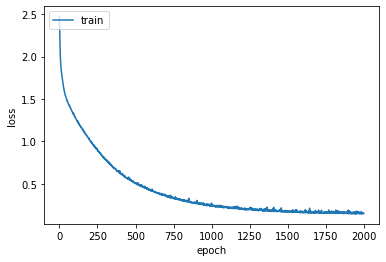

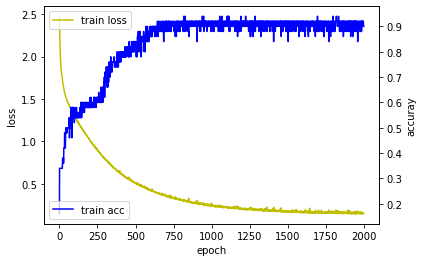

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.losses)
plt.plot()
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train'], loc='upper left')

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
#loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
#acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## 8 모델 평가하기

In [17]:
scores = model.evaluate(x_train, y_train)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

2/2 [==============================] - 0s 499us/step - loss: 0.1432 - accuracy: 0.9200
accuracy: 92.00%


## 9 모델 사용 하기 

In [18]:
pred_count = 50 # 최대 예측 개수 정의

### 9.1 한 스탭 예측 

In [19]:
seq_out = ['g8', 'e8', 'e4', 'f8']
pred_out = model.predict(x_train)

for i in range(pred_count):
    idx = np.argmax(pred_out[i])     # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx])    # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장
    
print("one step prediction : ", seq_out)

one step prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'e8', 'f8', 'g8', 'g8', 'g4', 'g8', 'e8', 'e8', 'e8', 'f8', 'g4', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'f4', 'e8', 'e8', 'e8', 'e8', 'f8', 'f8', 'g4', 'g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4']


### 9.2 곡 전체 예측 

In [20]:
seq_in = ['g8', 'e8', 'e4', 'f8']
seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in]    # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, 4)) # batch_size, feature
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)

print("full song prediction : ", seq_out)

full song prediction :  ['g8', 'e8', 'e4', 'f8', 'd8', 'd4', 'c8', 'e8', 'g8', 'g8', 'e8', 'e8', 'e4', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8', 'd8']
